In [1]:
import sys
sys.path.insert(1, '/home/main/Research/WingWatch')
#sys.path.insert(1, '/home/user/Research/base-WingWatch')

from WingWatch.Equipment import station
from WingWatch.Equipment import antenna
from WingWatch.Intersections import montecarlo
from WingWatch.Tools import translation
from WingWatch.Calibration import clean_data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Setup each of the actual stations

SEL_Station = station.Station('SEL',41.1534, -71.5521)

a1 = antenna.Antenna('1','yagi',0,434)
df = pd.read_csv('SE_Light_434_0_calib.csv')
a1.assign_pattern(df)
a1.convert_to_lat_long(SEL_Station)

a2 = antenna.Antenna('2','yagi',0,434)
df = pd.read_csv('SE_Light_434_1_calib.csv')
a2.assign_pattern(df)
a2.convert_to_lat_long(SEL_Station)

a3 = antenna.Antenna('3','yagi',0,434)
df = pd.read_csv('SE_Light_434_2_calib.csv')
a3.assign_pattern(df)
a3.convert_to_lat_long(SEL_Station)


a4 = antenna.Antenna('4','yagi',0,434)
df = pd.read_csv('SE_Light_434_3_calib.csv')
a4.assign_pattern(df)
a4.convert_to_lat_long(SEL_Station)

SEL_Station.add_antenna(a1)
SEL_Station.add_antenna(a2)
SEL_Station.add_antenna(a3)
SEL_Station.add_antenna(a4)

1 added to SEL's antennas.
2 added to SEL's antennas.
3 added to SEL's antennas.
4 added to SEL's antennas.


In [3]:
#Setup each of the actual stations

BRR_Station = station.Station('BRR',41.1479, -71.5901)

a1 = antenna.Antenna('1','yagi',0,434)
df = pd.read_csv('Black_Rock_434_0_calib.csv')
a1.assign_pattern(df)
a1.convert_to_lat_long(SEL_Station)

a2 = antenna.Antenna('2','yagi',0,434)
df = pd.read_csv('Black_Rock_434_1_calib.csv')
a2.assign_pattern(df)
a2.convert_to_lat_long(SEL_Station)

a3 = antenna.Antenna('3','yagi',0,434)
df = pd.read_csv('Black_Rock_434_2_calib.csv')
a3.assign_pattern(df)
a3.convert_to_lat_long(SEL_Station)


a4 = antenna.Antenna('4','yagi',0,434)
df = pd.read_csv('Black_Rock_434_3_calib.csv')
a4.assign_pattern(df)
a4.convert_to_lat_long(SEL_Station)

BRR_Station.add_antenna(a1)
BRR_Station.add_antenna(a2)
BRR_Station.add_antenna(a3)
BRR_Station.add_antenna(a4)

1 added to BRR's antennas.
2 added to BRR's antennas.
3 added to BRR's antennas.
4 added to BRR's antennas.


In [4]:
#Setup each of the actual stations

TUR_Station = station.Station('TUR',41.1256, -71.5075)

a1 = antenna.Antenna('1','yagi',0,434)
df = pd.read_csv('BIWF_Turbine1_0_calib.csv')
a1.assign_pattern(df)
a1.convert_to_lat_long(SEL_Station)

a2 = antenna.Antenna('2','yagi',0,434)
df = pd.read_csv('BIWF_Turbine1_1_calib.csv')
a2.assign_pattern(df)
a2.convert_to_lat_long(SEL_Station)

a3 = antenna.Antenna('3','yagi',0,434)
df = pd.read_csv('BIWF_Turbine1_2_calib.csv')
a3.assign_pattern(df)
a3.convert_to_lat_long(SEL_Station)


a4 = antenna.Antenna('4','yagi',0,434)
df = pd.read_csv('BIWF_Turbine1_3_calib.csv')
a4.assign_pattern(df)
a4.convert_to_lat_long(SEL_Station)

TUR_Station.add_antenna(a1)
TUR_Station.add_antenna(a2)
TUR_Station.add_antenna(a3)
TUR_Station.add_antenna(a4)

1 added to TUR's antennas.
2 added to TUR's antennas.
3 added to TUR's antennas.
4 added to TUR's antennas.


In [5]:
#At an epoch time of 1630333415, the test tag was at 41.127364,-71.492852,0

In [6]:
#Let us start working some geometries

df = pd.read_csv('allTagsAll390.csv',low_memory=False)

#BIWF goes offline on 11-29-2021
#SE Light goes offline on 12-25-2021
#Black Rock Goes offline on 5-26-2022



#remove any detections from the MOTUS project which are detected after the stations came down 
df['ts'] = pd.to_datetime(df['ts'])
df1 = df[df['ts'] < pd.to_datetime('2022-05-26')]

#filter just our recievers
mask = (df1['recvDeployName'] == 'Black_Rock_434') | (df1['recvDeployName'] == 'SE_Light_434') | (df1['recv'] == 'CTT-6A8468DA84C0')

#BIT is the Block Island Turbine
df_Black_Rock = df1[df1['recvDeployName'] == 'Black_Rock_434'].reset_index()
df_SE_Light = df1[df1['recvDeployName'] == 'SE_Light_434'].reset_index()
df_BIT = df1[df1['recv'] == 'CTT-6A8468DA84C0'].reset_index()

In [7]:
#Ground Truth Test - tsCorrected is in UNIX Time at GMT 

df_BR_GT = df_Black_Rock[(df_Black_Rock['tsCorrected'] >= 1630333415.0) & (df_Black_Rock['tsCorrected'] <= 1630333417.0)].reset_index()
df_SE_Light_GT = df_SE_Light[(df_SE_Light['tsCorrected'] >= 1630333415.0) & (df_SE_Light['tsCorrected'] <= 1630333417.0)].reset_index()
df_BIT_GT = df_BIT[(df_BIT['tsCorrected'] >= 1630333415.0) & (df_BIT['tsCorrected'] <= 1630333417.0)].reset_index()

In [8]:
def combine_simultaneous_timestamps(*timestamp_lists):
    combined_timestamps = {}
    
    for list_index, timestamps in enumerate(timestamp_lists):
        for index, timestamp in enumerate(timestamps):
            if timestamp in combined_timestamps:
                combined_timestamps[timestamp].append((list_index, index))
            else:
                combined_timestamps[timestamp] = [(list_index, index)]
    filtered_combined_timestamps = {timestamp: indexes for timestamp, indexes in combined_timestamps.items() if len(indexes) > 2}

    return filtered_combined_timestamps

# Example lists of time stamps
list1 = list(df_BIT_GT['tsCorrected'])
list2 = list(df_SE_Light_GT['tsCorrected'])
list3 = list(df_BR_GT['tsCorrected'])

combined = combine_simultaneous_timestamps(list1,list2, list3)


In [9]:
combined

{1630333415.0: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0)],
 1630333416.0: [(0, 3), (0, 4), (0, 5), (1, 3)],
 1630333417.0: [(0, 6), (0, 7), (0, 8), (1, 4), (1, 5), (2, 1)]}

In [10]:
a = combined[list(combined.keys())[0]]
key_list = list(combined.keys())
for i in range(len(a)):
    if a[i][0] == 0:
        data_column_rows = df_BIT_GT[df_BIT_GT.tsCorrected == key_list[0]] 
        #key_list[0] will need to change when dealing with multiple time iterations. it should be the same as the 
        # number that is indexing a, at the top of this box
        data_BIT = []
        for index,row in data_column_rows.iterrows():
            data_BIT.append([int(row['port'][-1]),row['sig']]) 
    if a[i][0] == 1:
        data_column_rows = df_SE_Light_GT[df_SE_Light_GT.tsCorrected == key_list[0]]
        data_SEL = []
        for index,row in data_column_rows.iterrows():
            data_SEL.append([int(row['port'][-1]),row['sig']])    
    if a[i][0] == 2:
        data_column_rows = df_BR_GT[df_BR_GT.tsCorrected == key_list[0]]
        data_BR = []
        for index,row in data_column_rows.iterrows():
            data_BR.append([int(row['port'][-1]),row['sig']])

In [11]:
data_BIT

[[3, -83.0], [4, -86.0], [2, -96.0]]

In [12]:
data_BR

[[1, -100.0]]

In [13]:
from WingWatch.Intersections.montecarlo import montecarlo_intersection
from WingWatch.Equipment import station
from WingWatch.Equipment import antenna
from WingWatch.Intersections import montecarlo
from WingWatch.Tools import translation
from WingWatch.Calibration import clean_data

station_data = [[data_BR,BRR_Station],[data_SEL,SEL_Station],[data_BIT,TUR_Station]]
points,index_map = montecarlo_intersection(station_data)

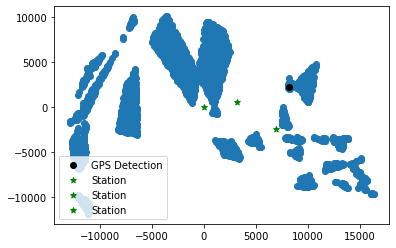

In [14]:
XY = points[index_map][:,0:2]
rot_mat = np.eye(2)
#rot_mat = np.array([[0,1],[-1,0]])
rot_points = np.matmul(XY,rot_mat)


plt.scatter(rot_points[:,0],rot_points[:,1])
plt.scatter(8166,2276,color="black",label='GPS Detection')
#plt.xlim(-20000, 20000)
#plt.ylim(-10000, 10000)
plt.scatter(0,0,marker='*',color='green',label='Station')
plt.scatter(3189,611,marker='*',color='green',label='Station')
plt.scatter(6936,-2473,marker='*',color='green',label='Station')
plt.legend(loc='lower left')
plt.savefig('Working_Triangulation_Algorithm_7_antennas.pdf')

In [15]:
a = combined[list(combined.keys())[1]]
key_list = list(combined.keys())
for i in range(len(a)):
    if a[i][0] == 0:
        data_column_rows = df_BIT_GT[df_BIT_GT.tsCorrected == key_list[1]] 
        #key_list[0] will need to change when dealing with multiple time iterations. it should be the same as the 
        # number that is indexing a, at the top of this box
        data_BIT = []
        for index,row in data_column_rows.iterrows():
            data_BIT.append([int(row['port'][-1]),row['sig']]) 
    if a[i][0] == 1:
        data_column_rows = df_SE_Light_GT[df_SE_Light_GT.tsCorrected == key_list[1]]
        data_SEL = []
        for index,row in data_column_rows.iterrows():
            data_SEL.append([int(row['port'][-1]),row['sig']])    
    if a[i][0] == 2:
        data_column_rows = df_BR_GT[df_BR_GT.tsCorrected == key_list[1]]
        data_BR = []
        for index,row in data_column_rows.iterrows():
            data_BR.append([int(row['port'][-1]),row['sig']])

In [16]:
station_data_1 = [[data_BR,BRR_Station],[data_SEL,SEL_Station],[data_BIT,TUR_Station]]
points_1,index_map_1 = montecarlo_intersection(station_data_1)

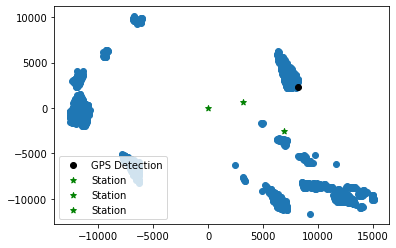

In [17]:
XY = points_1[index_map_1][:,0:2]
rot_mat = np.eye(2)
#rot_mat = np.array([[0,1],[-1,0]])
rot_points = np.matmul(XY,rot_mat)


plt.scatter(rot_points[:,0],rot_points[:,1])
plt.scatter(8166,2276,color="black",label='GPS Detection')
#plt.xlim(-20000, 20000)
#plt.ylim(-10000, 10000)
plt.scatter(0,0,marker='*',color='green',label='Station')
plt.scatter(3189,611,marker='*',color='green',label='Station')
plt.scatter(6936,-2473,marker='*',color='green',label='Station')
plt.legend(loc='lower left')

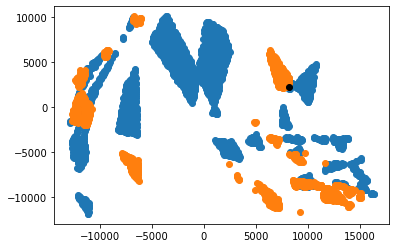

In [18]:
XY = points[index_map][:,0:2]
XY_1 = points_1[index_map_1][:,0:2]


plt.scatter(XY[:,0],XY[:,1])
plt.scatter(XY_1[:,0],XY_1[:,1])

plt.scatter(8166,2276,color="black",label='GPS Detection')


In [19]:
import random 


def generate_points_on_sphere(x0, y0, z0, r, n):
    # Generate random angles
    theta = np.random.uniform(0, 2 * np.pi, n)
    phi = np.arccos(np.random.uniform(-1, 1, n))
    
    # Convert spherical coordinates to Cartesian coordinates
    x = x0 + r * np.sin(phi) * np.cos(theta)
    y = y0 + r * np.sin(phi) * np.sin(theta)
    z = z0 + r * np.cos(phi)
    
    # Stack the coordinates to form an n x 3 array
    points = np.column_stack((x, y, z))
    
    return points



In [20]:
XYZ = points[index_map][:,:]
XYZ_1 = points_1[index_map_1]

In [21]:
XYZ_expanded = []
XYZ_1_expanded = []
for i in range(len(XYZ)):
    XYZ_expanded.append(generate_points_on_sphere(XYZ[i][0],XYZ[i][1],XYZ[i][2],340,100))
XYZ_expanded = np.row_stack(XYZ_expanded)
for i in range(len(XYZ_1)):
    XYZ_1_expanded.append(generate_points_on_sphere(XYZ_1[i][0],XYZ_1[i][1],XYZ_1[i][2],340,100))
XYZ_1_expanded = np.row_stack(XYZ_1_expanded)

In [22]:
ans = np.row_stack(XYZ_1_expanded)

In [23]:
ans[:,0]

array([6643.55981985, 6847.0036117 , 6854.61815552, ..., 7011.27296567,
       7177.08256639, 6821.09761656])

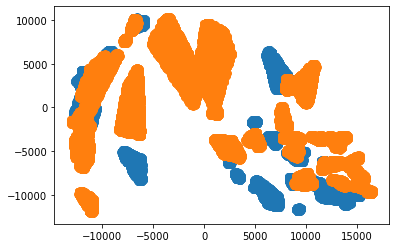

In [24]:
plt.scatter(XYZ_1_expanded[:,0],XYZ_1_expanded[:,1])
plt.scatter(XYZ_expanded[:,0],XYZ_expanded[:,1])

In [25]:
from scipy.spatial import KDTree

def find_intersection_with_kdtree(point_cloud1, point_cloud2, tol=1e-6):
    tree = KDTree(point_cloud2)
    intersection = []
    for point in point_cloud1:
        if tree.query(point, distance_upper_bound=tol)[0] < tol:
            intersection.append(point)
    return np.array(intersection)

# Example usage
intersection_points = find_intersection_with_kdtree(XYZ, XYZ_1, tol=300)
print(intersection_points)


[[ -6875.45628451   9780.21980489   -164.54688673]
 [  8613.95128521  -5100.86128473   -608.6930503 ]
 [  8113.1577106    2626.40560737   -741.57560237]
 [-12038.3433845   -1304.3127734   -1112.12193549]
 [  8078.44854782   2193.63646995   -411.55105415]
 [  9364.50965346  -8084.99046854  -1200.21338113]
 [ 10398.73949484  -8524.50629996  -1328.10770178]
 [  8971.95911785  -8711.34550337   -876.85905513]
 [  9785.979094    -8681.17613293   -470.83834572]
 [  8219.07529242   2212.19889352  -1427.71948973]
 [  8047.64814778   2165.30431608  -1424.47149406]
 [-12229.02592738   -867.80243521  -1070.3220473 ]
 [  9450.88359257  -8621.74043195   -876.29108995]
 [  9240.9842463   -8018.97915693   -111.52611135]
 [-12180.48879745  -1149.70872099   -294.18662812]
 [  9428.23728432  -8042.23269938   -959.50723106]
 [-11548.63075242   2983.10226486    -29.22445102]
 [  9514.60399948  -8152.3443156   -1239.232338  ]
 [-11305.15980246   -189.92043854   -888.61289538]
 [  9729.60401777  -8822.289505

(7916.0, 8416.0)

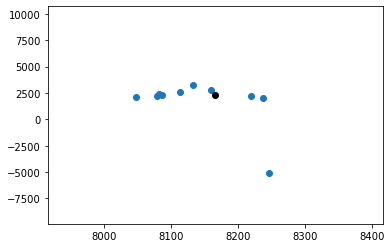

In [26]:
plt.scatter(intersection_points[:,0],intersection_points[:,1])
plt.scatter(8166,2276,color="black",label='GPS Detection')
plt.xlim([8166-250,8166+250])

In [27]:
a = combined[list(combined.keys())[2]]
key_list = list(combined.keys())
for i in range(len(a)):
    if a[i][0] == 0:
        data_column_rows = df_BIT_GT[df_BIT_GT.tsCorrected == key_list[2]] 
        #key_list[0] will need to change when dealing with multiple time iterations. it should be the same as the 
        # number that is indexing a, at the top of this box
        data_BIT = []
        for index,row in data_column_rows.iterrows():
            data_BIT.append([int(row['port'][-1]),row['sig']]) 
    if a[i][0] == 1:
        data_column_rows = df_SE_Light_GT[df_SE_Light_GT.tsCorrected == key_list[2]]
        data_SEL = []
        for index,row in data_column_rows.iterrows():
            data_SEL.append([int(row['port'][-1]),row['sig']])    
    if a[i][0] == 2:
        data_column_rows = df_BR_GT[df_BR_GT.tsCorrected == key_list[2]]
        data_BR = []
        for index,row in data_column_rows.iterrows():
            data_BR.append([int(row['port'][-1]),row['sig']])

In [28]:
station_data_2 = [[data_BR,BRR_Station],[data_SEL,SEL_Station],[data_BIT,TUR_Station]]
points_2,index_map_2 = montecarlo_intersection(station_data_2)

In [29]:
XYZ_2 = points_2[index_map_2][:,:]

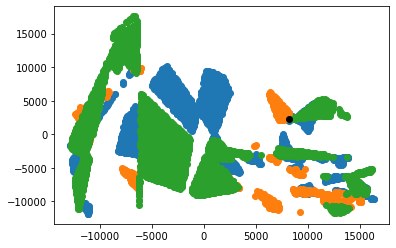

In [30]:
plt.scatter(XY[:,0],XY[:,1])
plt.scatter(XY_1[:,0],XY_1[:,1])
plt.scatter(XYZ_2[:,0],XYZ_2[:,1])
plt.scatter(8166,2276,color="black",label='GPS Detection')


In [31]:
from scipy.spatial import KDTree

def find_intersection_with_kdtree(point_cloud1, point_cloud2, tol=1e-6):
    tree = KDTree(point_cloud2)
    intersection = []
    for point in point_cloud1:
        if tree.query(point, distance_upper_bound=tol)[0] < tol:
            intersection.append(point)
    return np.array(intersection)

# Example usage
intersection_points_1 = find_intersection_with_kdtree(XYZ_2, intersection_points, tol=200)

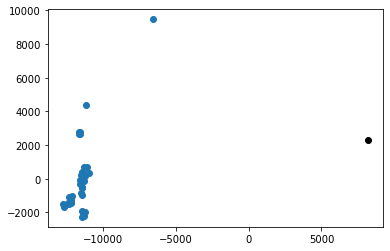

In [32]:
plt.scatter(intersection_points_1[:,0],intersection_points_1[:,1])
plt.scatter(8166,2276,color="black",label='GPS Detection')